In [1]:
# Import necessary libraries
import os
import sys
# Add the utils folder to the system path so we can import custom modules
sys.path.append(os.path.abspath("utils"))
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from utils.reproducibility_utils import seed_everything
from utils.data_loading import load_data, load_test_data, feature_names

# Set the plotting style for better-looking visualizations
plt.style.available
plt.style.use('seaborn-v0_8')

In [2]:
# Set random seed for reproducibility across runs
# This ensures that your results will be the same every time you run the notebook
seed_everything(42)  # for reproducibility

# Load the Data

# Getting Started with the Competition

This notebook will guide you through the complete workflow for participating in the sideslip angle prediction challenge:

## Workflow Overview:
1. **Load and preprocess data** - Learn about proper train/validation/test splitting
2. **Explore the data** - Understand the input features and target variable  
3. **Build a neural network** - Implement a simple RNN architecture
4. **Train the model** - Use best practices like early stopping and model checkpointing
5. **Evaluate performance** - Validate your model and visualize predictions
6. **Make predictions** - Generate test set predictions for submission

Let's begin! 🚀

## Understanding Data Preprocessing

When loading data for machine learning, we need to follow these critical principles:

**1. Statistical Integrity:** Train, validation, and test sets must be processed consistently
- All preprocessing steps (standardization, thresholding) must be identical across all datasets
- This ensures fair evaluation and prevents data leakage

**2. Standardization Best Practice:**
- Calculate mean and standard deviation **ONLY** on the training set
- Apply these same statistics to validation and test sets
- This simulates real-world conditions where we don't have access to future data

**Why this matters:** In production, your model will only know the statistics from training data. Calculating statistics on validation or test data would give unrealistic performance estimates.

In [3]:
print("Loading train data...")
train_dataloader, val_dataloader, pipeline = load_data(
    train_path = "datasets_challenge/train",  # Path to training data
    train_ratio = 0.8,  # Use 80% for training, 20% for validation
    batchsize = 512,  # Number of samples per batch
    # columns_to_standardize = feature_names,  # Option to specify which columns to standardize
    columns_to_drop = ["sideSlip", "vyCG", "time", "longitude","latitude"],  # Remove these from features
    sequence_length = 20,  # Number of time steps in each sequence (t-19 to t0)
    threshold = True,  # Enable velocity thresholding
    threshold_value = 3.0,  # Only keep samples where vehicle speed > 3 m/s
    threshold_column = "vxCG",  # Column to apply threshold on (longitudinal velocity)
    target = "sideSlip",  # The variable we want to predict
    scaling = True,  # Apply standardization to features
    seed = 42,  # Random seed for train/val split
)

Loading train data...
datasets_challenge/train\train_part_001.csv
datasets_challenge/train\train_part_002.csv
datasets_challenge/train\train_part_003.csv
datasets_challenge/train\train_part_004.csv
datasets_challenge/train\train_part_005.csv
datasets_challenge/train\train_part_006.csv
datasets_challenge/train\train_part_007.csv
datasets_challenge/train\train_part_008.csv
datasets_challenge/train\train_part_009.csv
datasets_challenge/train\train_part_010.csv
datasets_challenge/train\train_part_011.csv
datasets_challenge/train\train_part_012.csv
datasets_challenge/train\train_part_013.csv
datasets_challenge/train\train_part_014.csv
datasets_challenge/train\train_part_015.csv
datasets_challenge/train\train_part_016.csv
datasets_challenge/train\train_part_017.csv
datasets_challenge/train\train_part_018.csv
datasets_challenge/train\train_part_019.csv
datasets_challenge/train\train_part_020.csv
datasets_challenge/train\train_part_021.csv
datasets_challenge/train\train_part_022.csv


## Applying label densities to each label

In [4]:
#print(type(train_dataloader.dataset.dataset.datasets[0].y))  # Inspect the dataset structure
#for i  in range(42):
    #print((train_dataloader.dataset.dataset.datasets[i].y[:10]))  # Check shape of target variable
print(len(train_dataloader.dataset.dataset.datasets[0].densities))  # Inspect the dataset structure

TypeError: object of type 'NoneType' has no len()

## test 0

In [ ]:
import torch
import numpy as np
from sklearn.neighbors import KernelDensity

def extract_all_targets(dataset):
    """Recursively extract all target labels (y) from nested datasets."""
    if isinstance(dataset, torch.utils.data.Subset):
        # Extract from the underlying dataset using subset indices
        base_dataset = dataset.dataset
        indices = dataset.indices
        return extract_all_targets(base_dataset)[indices]
    
    elif isinstance(dataset, torch.utils.data.ConcatDataset):
        # Concatenate all targets from each sub-dataset
        ys = [extract_all_targets(d) for d in dataset.datasets]
        return torch.cat(ys, dim=0)
    
    elif hasattr(dataset, "y"):
        # Base dataset (e.g. sequential_dataset)
        return dataset.y
    
    else:
        raise AttributeError(f"Cannot find target labels in dataset type: {type(dataset)}")

def apply_label_density(dataset, bandwidth=0.1):
    """Compute label densities from any nested dataset structure."""
    all_targets = extract_all_targets(dataset)

    if torch.is_tensor(all_targets):
        all_targets = all_targets.numpy()

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(all_targets.reshape(-1, 1))
    densities = np.exp(kde.score_samples(all_targets.reshape(-1, 1)))

    # Normalize to [0, 1]
    densities = (densities - densities.min()) / (densities.max() - densities.min())
    return densities




densities = apply_label_density(train_dataloader.dataset.dataset, bandwidth=0.5)
train_dataloader.dataset.dataset.datasets.densities = torch.tensor(densities, dtype=torch.float32)

## test 1

In [ ]:
# applying label density based on kernel smoothing
def apply_label_density(datasets, bandwidth=0.1):
    all_targets = []
    all_targets = torch.cat([
        d.y 
        if isinstance(d.y, torch.Tensor) 
        else torch.as_tensor(d.y)
        for d in datasets
    ], dim=0)
    print(f"Total number of targets: {len(all_targets)}")


    # Kernel density estimation
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(all_targets.reshape(-1, 1))
    
    densities = np.exp(kde.score_samples(all_targets.reshape(-1, 1)))
    
    # Normalize densities to [0, 1]
    densities = (densities - densities.min()) / (densities.max() - densities.min())

    densities = torch.tensor(densities, dtype=torch.float32)
    print(f"Densities shape: {densities.shape}")
    start = 0
    for d in datasets:
        n = len(d.y)
        d.densities = densities[start:start + n]
        start += n
        print(f"Assigned densities to dataset with {n} samples.")
    return densities

densities = apply_label_density(train_dataloader.dataset.dataset.datasets, bandwidth=0.5)

## test 2 - working

In [5]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Applying label density based on binning + Gaussian smoothing
def apply_label_density(datasets, num_bins, sigma=2):
    """
    Compute smoothed label densities for regression targets using binning + Gaussian smoothing.

    Args:
        datasets: list of datasets, each with attribute .y
        num_bins: number of bins for discretizing target space
        sigma: standard deviation for Gaussian smoothing

    Returns:
        densities: tensor of smoothed densities for all targets
    """
    # 1. Collect all targets into one tensor
    all_targets = torch.cat([
        d.y if isinstance(d.y, torch.Tensor) else torch.as_tensor(d.y)
        for d in datasets
    ], dim=0)
    print(f"Total number of targets: {len(all_targets)}")

    # 2. Create bins over the target range
    y_min, y_max = all_targets.min().item(), all_targets.max().item()
    bins = torch.linspace(y_min, y_max, num_bins)

    # 3. Compute histogram (count targets in each bin)
    hist = torch.histc(all_targets.float(), bins=num_bins, min=y_min, max=y_max)

    # 4. Smooth histogram with Gaussian filter
    smoothed = gaussian_filter1d(hist.numpy(), sigma=sigma)

    # 5. Interpolate densities back to original targets
    densities = np.interp(all_targets.numpy(), bins.numpy(), smoothed)

    # 6. Normalize densities to [0, 1]
    densities = (densities - densities.min()) / (densities.max() - densities.min())
    densities = torch.tensor(densities, dtype=torch.float32)
    print(f"Densities shape: {densities.shape}")

    # 7. Assign densities back to individual datasets
    start = 0
    for d in datasets:
        n = len(d.y)
        d.densities = densities[start:start + n]
        start += n
        print(f"Assigned densities to dataset with {n} samples.")

    return densities

# Example usage
densities = apply_label_density(train_dataloader.dataset.dataset.datasets, num_bins=1000, sigma=2)


Total number of targets: 137920
Densities shape: torch.Size([137920])
Assigned densities to dataset with 11841 samples.
Assigned densities to dataset with 88 samples.
Assigned densities to dataset with 767 samples.
Assigned densities to dataset with 329 samples.
Assigned densities to dataset with 8684 samples.
Assigned densities to dataset with 799 samples.
Assigned densities to dataset with 482 samples.
Assigned densities to dataset with 149 samples.
Assigned densities to dataset with 1201 samples.
Assigned densities to dataset with 324 samples.
Assigned densities to dataset with 19721 samples.
Assigned densities to dataset with 377 samples.
Assigned densities to dataset with 174 samples.
Assigned densities to dataset with 234 samples.
Assigned densities to dataset with 96 samples.
Assigned densities to dataset with 984 samples.
Assigned densities to dataset with 407 samples.
Assigned densities to dataset with 47 samples.
Assigned densities to dataset with 22220 samples.
Assigned dens

In [6]:
print((train_dataloader.dataset.dataset.datasets[0].densities[:10]))

tensor([0.0492, 0.0528, 0.0401, 0.0159, 0.0153, 0.0270, 0.0163, 0.0179, 0.0183,
        0.0146])


# Visualize an Example of a single sample

## Understanding the Input Data Structure

Before training, let's examine what a single sample looks like:

- **Shape:** Each sample contains 22 features over a sequence of 20 time steps
- **Time dimension:** The leftmost column represents t₋₁₉ (19 steps in the past), and the rightmost is t₀ (current time)
- **Features:** Each colored line represents a different sensor measurement (speed, acceleration, steering angle, etc.)
- **Target:** The sideslip angle shown in the title is what we're trying to predict at time t₀

**Note:** The values appear chaotic because they're standardized (mean=0, std=1). This helps the neural network learn more effectively.

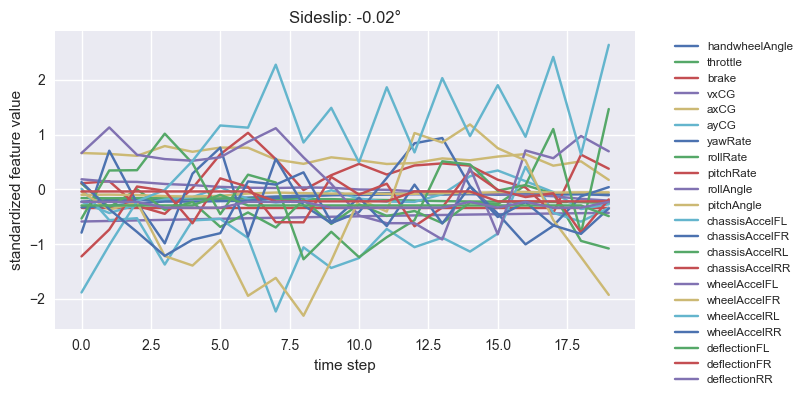

In [7]:
# Get one batch of data from the training dataloader
X, y,d = next(iter(train_dataloader))

# Visualize the first sample in the batch
plt.figure(figsize=(8,4))
plt.plot(X[0,:,:], label=feature_names)  # Plot all 22 features over 20 time steps
plt.title("Sideslip: "+str(round(y[0].item(),2))+"°")  # Show the target value
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.xlabel("time step")
plt.ylabel("standardized feature value")
plt.show()

# Train an example model

## Why Use a Recurrent Neural Network (RNN)?

For this task, we'll use a simple RNN architecture. Here's why:

**Sequential Data:** Our input is a time series (20 time steps of sensor data). RNNs are specifically designed to handle sequential data by maintaining an internal "memory" of previous time steps.

**How RNNs Work:**
- They process the sequence step by step (t₋₁₉, t₋₁₈, ..., t₀)
- At each step, they update their hidden state based on the current input and previous hidden state
- This allows them to capture temporal patterns and dependencies

**Architecture Overview:**
- **Input:** Sequential sensor data (20 time steps × 22 features)
- **RNN Layer:** Processes the sequence and captures temporal patterns
- **Fully Connected Layers:** Transform RNN output to final prediction
- **Output:** Single value (predicted sideslip angle)

In [ ]:
class RNN(nn.Module):
    """
    Recurrent Neural Network for sideslip angle prediction.
    
    Architecture:
    1. RNN Layer - Processes sequential input
    2. Fully Connected Layer - Transforms RNN output
    3. Output Layer - Produces final prediction
    
    Dropout layers are included to prevent overfitting.
    """
    def __init__(self, input_size, output_size=1, rnn_units=64, fc_units=64, 
                 activation_fct=nn.ReLU(), dropout=[0.2, 0, 0], rnn_nonlinearity='relu'):
        super(RNN, self).__init__()
        
        # RNN layer: processes the sequence and captures temporal dependencies
        self.rnn_layer = nn.RNN(input_size=input_size, hidden_size=rnn_units, 
                                num_layers=1, nonlinearity=rnn_nonlinearity, batch_first=True)
        
        # Fully connected layers for processing RNN output
        self.fc = nn.Linear(rnn_units, fc_units)
        self.output_layer = nn.Linear(fc_units, output_size)
        
        # Dropout layers to prevent overfitting (randomly zeros out neurons during training)
        self.dropout1 = nn.Dropout(dropout[0])  # Applied to input
        self.dropout2 = nn.Dropout(dropout[1])  # Applied after RNN
        self.dropout3 = nn.Dropout(dropout[2])  # Applied after FC layer
        
        self.activation_fct = activation_fct
 
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        x = self.dropout1(x)
        
        # Process sequence through RNN
        x, _ = self.rnn_layer(x)  # Output shape: (batch_size, sequence_length, rnn_units)
        
        # Take only the last time step's output (t0)
        x = x[:, -1, :]  # Shape: (batch_size, rnn_units)
        
        x = self.dropout2(x)
        x = self.activation_fct(self.fc(x))  # Apply fully connected layer with activation
        x = self.dropout3(x)
        x = self.output_layer(x)  # Final prediction
        
        return x

In [ ]:
# Set device for computation (CPU or GPU)
device = "cpu"  # Change to "cuda" if you have a GPU available

# Model hyperparameters
input_size = X.shape[2]  # Number of features (22 in this case)
rnn_units = 128  # Number of units in RNN hidden state
fc_units = 128  # Number of units in fully connected layer
output_size = 1  # Single output (sideslip angle)
lr = 0.0003  # Learning rate for optimizer

# Initialize the model with specified architecture
model = RNN(
    input_size=input_size, 
    output_size=output_size,
    rnn_units=rnn_units,
    fc_units=fc_units,
    dropout=[0.2, 0.1, 0.05]  # Dropout rates for [input, after_rnn, after_fc]
).to(device)

# Define loss function and optimizer
criterion = nn.L1Loss()  # Mean Absolute Error (MAE) - measures average prediction error
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for weight updates

# Testing with GRU + CNN - test
Only GRU performs better than +CNN

In [8]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size=1, rnn_units=32, fc_units=32):
        super().__init__()
        # self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, padding=1) #CNN layer makes the performance little bad
        self.gru = nn.GRU(input_size, rnn_units, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(rnn_units*2, 1)
        self.layernorm = nn.LayerNorm(rnn_units*2)
        self.fc = nn.Sequential(
            nn.Linear(rnn_units*2, fc_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(fc_units, output_size)
        )

    def forward(self, x):
        x, _ = self.gru(x)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(attn_weights * x, dim=1)
        context = self.layernorm(context)
        return self.fc(context)
print("Model definitions complete.")

Model definitions complete.


In [9]:
#test
# Set device for computation (CPU or GPU)
device = "cpu"  # Change to "cuda" if you have a GPU available

# Model hyperparameters
input_size = X.shape[2]  # Number of features (22 in this case)
rnn_units = 128  # Number of units in RNN hidden state
fc_units = 128  # Number of units in fully connected layer
output_size = 1  # Single output (sideslip angle)
lr = 0.0003  # Learning rate for optimizer

model = GRU(
    input_size=input_size,
    fc_units=fc_units,
    rnn_units=rnn_units,
).to(device)

# Define loss function and optimizer
criterion = nn.L1Loss()  # Mean Absolute Error (MAE) - measures average prediction error
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for weight updates

## Given

In [ ]:
# Training configuration
num_epochs = 30  # Maximum number of training epochs
early_stop_thresh = 10  # Stop if no improvement for this many epochs
best_loss = np.inf  # Initialize with infinity
best_epoch = -1
best_model_state = None  # Will store the best model weights

# Lists to track training progress
train_curve = []
val_curve = []

for epoch in range(num_epochs):
    running_loss = 0
    
    # ========== TRAINING PHASE ==========
    model.train()  # Set model to training mode (enables dropout)
    for step, (x, y) in enumerate(train_dataloader):
        # Move data to device and reshape target
        X, y = x.to(device), y.to(device).reshape([len(y), 1])
        
        optimizer.zero_grad()  # Reset gradients from previous iteration
        pred = model(X)  # Forward pass: get predictions
        train_loss = criterion(pred, y)  # Calculate loss
        running_loss += train_loss.item()
        train_loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model weights
    
    avg_train_loss = running_loss / step
    train_curve.append(avg_train_loss)

    # ========== VALIDATION PHASE ==========
    model.eval()  # Set model to evaluation mode (disables dropout)
    running_val_loss = 0
    with torch.no_grad():  # Disable gradient computation (saves memory and computation)
        for val_step, (x, y) in enumerate(val_dataloader):
            X_val, y_val = x.to(device), y.to(device).reshape([len(y), 1])
            val_loss = criterion(model(X_val), y_val)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / val_step
    val_curve.append(avg_val_loss)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}", end="")
    
    # ========== EARLY STOPPING & MODEL CHECKPOINTING ==========
    if avg_val_loss < best_loss:
        # New best model found - save it!
        best_loss = avg_val_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss
        }, 'best_model.pth')
        print(f"  → New best validation loss: {best_loss:.5f}")
    elif epoch - best_epoch > early_stop_thresh:
        # No improvement for too long - stop training
        print(f"  → Early stopping triggered at epoch {epoch+1} (best epoch: {best_epoch+1})")
        break
    else:
        print("")

# ========== LOAD BEST MODEL ==========
if best_epoch != -1:
    checkpoint = torch.load('best_model.pth', weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\n✓ Best model from epoch {best_epoch+1} loaded (Val Loss: {best_loss:.5f})")
else:
    print("\n⚠ No improvement found, using current model")

## Training based on label density - test 0

In [10]:
def weighted_focal_mse_loss(y_pred, y_true, label_density, alpha=0.6, beta=2.0, gamma=1.0, eps=1e-6):
    weights = (1.0 / (label_density + eps)) ** alpha
    error = torch.abs(y_pred - y_true)
    focal_weight = (1 - torch.exp(-beta * error)) ** gamma
    loss = (weights * focal_weight * error**2).mean()
    return loss

In [11]:
# Training configuration
num_epochs = 30  # Maximum number of training epochs
early_stop_thresh = 10  # Stop if no improvement for this many epochs
best_loss = np.inf  # Initialize with infinity
best_epoch = -1
best_model_state = None  # Will store the best model weights

# Lists to track training progress
train_curve = []
val_curve = []

for epoch in range(num_epochs):
    running_loss = 0
    
    # ========== TRAINING PHASE ==========
    model.train()  # Set model to training mode (enables dropout)
    for step, (x, y, densities) in enumerate(train_dataloader):
        # Move data to device and reshape target
        X, y = x.to(device), y.to(device).reshape([len(y), 1])
        optimizer.zero_grad()  # Reset gradients from previous iteration
        pred = model(X)  # Forward pass: get predictions
        train_loss = weighted_focal_mse_loss(pred, y, densities.to(device))  # Calculate loss
        running_loss += train_loss.item()
        train_loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model weights
    
    avg_train_loss = running_loss / step
    train_curve.append(avg_train_loss)

    # ========== VALIDATION PHASE ==========
    model.eval()  # Set model to evaluation mode (disables dropout)
    running_val_loss = 0
    with torch.no_grad():  # Disable gradient computation (saves memory and computation)
        for val_step, (x, y, d) in enumerate(val_dataloader):
            X_val, y_val, d_val = x.to(device), y.to(device).reshape([len(y), 1]), d.to(device)
            y_pred = model(X_val)
            #val_loss = weighted_focal_mse_loss(model(X_val), y_val, torch.ones_like(y_val).to(device))  # Use uniform density for val
            val_loss = weighted_focal_mse_loss(y_pred, y_val, d_val)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / val_step
    val_curve.append(avg_val_loss)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}", end="")
    
    # ========== EARLY STOPPING & MODEL CHECKPOINTING ==========
    if avg_val_loss < best_loss:
        # New best model found - save it!
        best_loss = avg_val_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss
        }, 'best_model.pth')
        print(f"  → New best validation loss: {best_loss:.5f}")
    elif epoch - best_epoch > early_stop_thresh:
        # No improvement for too long - stop training
        print(f"  → Early stopping triggered at epoch {epoch+1} (best epoch: {best_epoch+1})")
        break
    else:
        print("")

# ========== LOAD BEST MODEL ==========
if best_epoch != -1:
    checkpoint = torch.load('best_model.pth', weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\n✓ Best model from epoch {best_epoch+1} loaded (Val Loss: {best_loss:.5f})")
else:
    print("\n⚠ No improvement found, using current model")

Epoch 1/30 | Train Loss: 1.64813 | Val Loss: 0.64095  → New best validation loss: 0.64095
Epoch 2/30 | Train Loss: 0.43866 | Val Loss: 0.27190  → New best validation loss: 0.27190
Epoch 3/30 | Train Loss: 0.26611 | Val Loss: 0.19640  → New best validation loss: 0.19640
Epoch 4/30 | Train Loss: 0.23065 | Val Loss: 0.18558  → New best validation loss: 0.18558
Epoch 5/30 | Train Loss: 0.21333 | Val Loss: 0.16834  → New best validation loss: 0.16834
Epoch 6/30 | Train Loss: 0.20215 | Val Loss: 0.16957
Epoch 7/30 | Train Loss: 0.19861 | Val Loss: 0.15803  → New best validation loss: 0.15803
Epoch 8/30 | Train Loss: 0.18833 | Val Loss: 0.15391  → New best validation loss: 0.15391
Epoch 9/30 | Train Loss: 0.18208 | Val Loss: 0.14386  → New best validation loss: 0.14386
Epoch 10/30 | Train Loss: 0.17865 | Val Loss: 0.14470
Epoch 11/30 | Train Loss: 0.17731 | Val Loss: 0.14102  → New best validation loss: 0.14102
Epoch 12/30 | Train Loss: 0.17092 | Val Loss: 0.21893
Epoch 13/30 | Train Loss: 0.

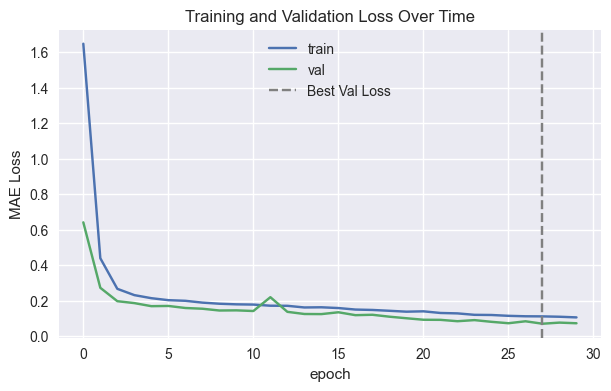

In [12]:
# Visualize training progress
plt.figure(figsize=(7, 4))
plt.plot(train_curve, label="train")
plt.plot(val_curve, label="val")
plt.axvline(x=best_epoch, color='gray', linestyle='--', label='Best Val Loss')
plt.xlabel("epoch")
plt.ylabel("MAE Loss")
plt.legend()
plt.title("Training and Validation Loss Over Time")
plt.show()

# Evaluate the Training

## Understanding the Training Curves

Looking at the plot above, you should observe:

**Good signs:**
- Training loss decreases steadily
- Validation loss decreases and stabilizes
- The gap between train and validation is small (indicates good generalization)

**Warning signs to watch for:**
- Large gap between train and val = **overfitting** (model memorizes training data)
- Both losses stay high = **underfitting** (model is too simple)
- Validation loss increases while training decreases = **overfitting**

The vertical dashed line shows where we achieved the best validation performance.

## Verification Step

Let's verify that we correctly loaded the best model by evaluating it one more time on the validation set. The loss should match the best validation loss from training.

## test 0 with density based loss

In [15]:
# Evaluate model on validation set
model.eval()
running_val_loss = 0.0

with torch.no_grad():
    for val_step, (x, y, d) in enumerate(val_dataloader):
        X_val = x.to(device)
        y_val = y.to(device).reshape(-1, 1)
        d_val = d.to(device)  # label density for weighting

        y_pred = model(X_val)
        val_loss = weighted_focal_mse_loss(y_pred, y_val, d_val)

        running_val_loss += val_loss.item()

avg_val_loss = running_val_loss / (val_step + 1)
print(f"Final Evaluation on Validation Set - Weighted Focal MSE Loss: {avg_val_loss:.5f}")

Final Evaluation on Validation Set - Weighted Focal MSE Loss: 0.06827


## Given

In [14]:
# Evaluate the loaded model on validation set
model.eval()
running_val_loss = 0
with torch.no_grad():
    for val_step, (x, y, d) in enumerate(val_dataloader):
        X_val, y_val = x.to(device), y.to(device).reshape([len(y), 1])
        val_loss = criterion(model(X_val), y_val)
        running_val_loss += val_loss.item()

avg_val_loss = running_val_loss / val_step

print(f"Final Evaluation on Validation Set - MAE Loss: {avg_val_loss:.5f}")

Final Evaluation on Validation Set - MAE Loss: 0.13727


## Visual Sanity Check

Now let's load the complete training dataset (without shuffling) to visualize how well our model captures the sideslip signal pattern.

**Important Note:** We're loading ALL training data here (including what was used for validation), so the model will perform slightly better than the validation loss suggests. This is called **data leakage** and should normally be avoided in proper evaluation. However, for visualization purposes, this helps us see that the model learned meaningful patterns.

In [16]:
# Load complete training data (unshuffled) for visualization
# This uses the same preprocessing pipeline to ensure consistency
train_dataloader_unshuffled = load_test_data(
    test_path="datasets_challenge/train",
    batchsize=512,
    pipeline=pipeline,  # Use the same preprocessing as training
    load_anonymized_data=False  # We have ground truth for training data
)

datasets_challenge/train\train_part_001.csv
datasets_challenge/train\train_part_002.csv
datasets_challenge/train\train_part_003.csv
datasets_challenge/train\train_part_004.csv
datasets_challenge/train\train_part_005.csv
datasets_challenge/train\train_part_006.csv
datasets_challenge/train\train_part_007.csv
datasets_challenge/train\train_part_008.csv
datasets_challenge/train\train_part_009.csv
datasets_challenge/train\train_part_010.csv
datasets_challenge/train\train_part_011.csv
datasets_challenge/train\train_part_012.csv
datasets_challenge/train\train_part_013.csv
datasets_challenge/train\train_part_014.csv
datasets_challenge/train\train_part_015.csv
datasets_challenge/train\train_part_016.csv
datasets_challenge/train\train_part_017.csv
datasets_challenge/train\train_part_018.csv
datasets_challenge/train\train_part_019.csv
datasets_challenge/train\train_part_020.csv
datasets_challenge/train\train_part_021.csv
datasets_challenge/train\train_part_022.csv


c:\Users\Pratheek\anaconda3\envs\aiml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## Interactive Visualization with Plotly

We use Plotly for this visualization because it allows you to:
- **Zoom in/out** to examine specific regions
- **Pan** across the signal
- **Hover** to see exact values

**What to look for:**
- The red line (predictions) should closely follow the blue line (ground truth)
- The model should capture both large trends and smaller variations
- Performance is slightly better here than validation because this includes training data

**Note:** If Plotly doesn't work in your environment, you can replace it with matplotlib by using `plt.plot()`.

## test 0 with density based loss

In [18]:
import plotly.graph_objects as go

# Set model to evaluation mode
model.eval()

# Storage for predictions and ground truth
total_loss = 0  
preds = []
ground_truths = []

# Generate predictions for all training data
with torch.no_grad():
    for step, (x, y) in enumerate(train_dataloader_unshuffled):
        X, y, d = x.to(device), y.to(device).reshape([len(y), 1]), d.to(device)

        pred = model(X)
        loss = weighted_focal_mse_loss(pred, y, d)
        total_loss += loss.item()
        
        # Store predictions and ground truth
        preds.append(pred.reshape(-1).cpu().numpy())
        ground_truths.append(y.reshape(-1).cpu().numpy())

    print(f"Avg. Loss: {total_loss/step}")
    
    # Concatenate all batches into single arrays
    ground_truths = np.concatenate(ground_truths)
    preds = np.concatenate(preds)

# Create interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(y=ground_truths, mode='lines', name='truth', line=dict(color='blue')))
fig.add_trace(go.Scatter(y=preds.flatten(), mode='lines', name='pred', line=dict(color='red'), opacity=0.8))
fig.update_layout(
    title='Ground Truth vs Predictions',
    xaxis_title='Sample Index',
    yaxis_title='Sideslip Angle (degrees)',
    width=1200,
    height=500
)
fig.show()

Avg. Loss: 0.06260872112712666


## given

In [ ]:
import plotly.graph_objects as go

# Set model to evaluation mode
model.eval()

# Storage for predictions and ground truth
total_loss = 0  
preds = []
ground_truths = []

# Generate predictions for all training data
with torch.no_grad():
    for step, (x, y) in enumerate(train_dataloader_unshuffled):
        X, y = x.to(device), y.to(device).reshape([len(y), 1])

        pred = model(X)
        loss = criterion(pred, y)
        total_loss += loss.item()
        
        # Store predictions and ground truth
        preds.append(pred.reshape(-1).cpu().numpy())
        ground_truths.append(y.reshape(-1).cpu().numpy())

    print(f"Avg. Loss: {total_loss/step}")
    
    # Concatenate all batches into single arrays
    ground_truths = np.concatenate(ground_truths)
    preds = np.concatenate(preds)

# Create interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(y=ground_truths, mode='lines', name='truth', line=dict(color='blue')))
fig.add_trace(go.Scatter(y=preds.flatten(), mode='lines', name='pred', line=dict(color='red'), opacity=0.8))
fig.update_layout(
    title='Ground Truth vs Predictions',
    xaxis_title='Sample Index',
    yaxis_title='Sideslip Angle (degrees)',
    width=1200,
    height=500
)
fig.show()

# Participating in the Challenge

Now it's time to make predictions on the official test set and prepare your submission!

## Important Notes About Test Data:

1. **No Ground Truth:** The test set has placeholder sideslip values of 0, so we cannot calculate a real loss
2. **Consistent Preprocessing:** We use the same `pipeline` object to ensure identical preprocessing as training
3. **Anonymized Data:** Set `load_anonymized_data=True` to indicate we don't have real targets

Your goal is to generate predictions for all test samples and save them in the correct format for submission.

In [19]:
print("\nLoading test data...")
test_dataloader = load_test_data(test_path = "datasets_challenge/test",
                                 batchsize = 512,
                                 pipeline = pipeline, 
                                 load_anonymized_data=True)


Loading test data...
datasets_challenge/test\test_part_001.csv
datasets_challenge/test\test_part_002.csv
datasets_challenge/test\test_part_003.csv
datasets_challenge/test\test_part_004.csv
datasets_challenge/test\test_part_005.csv
datasets_challenge/test\test_part_006.csv
datasets_challenge/test\test_part_007.csv
datasets_challenge/test\test_part_008.csv
datasets_challenge/test\test_part_009.csv
datasets_challenge/test\test_part_010.csv
datasets_challenge/test\test_part_011.csv


c:\Users\Pratheek\anaconda3\envs\aiml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning:

This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.



## test 0 with density based loss

In [20]:
# Generate predictions on test set
model.eval()
total_loss = 0  
test_preds = []
test_ground_truths = []  # Will contain placeholder values (all zeros)

with torch.no_grad():
    for step, (x, y) in enumerate(test_dataloader):
        X, y, d = x.to(device), y.to(device).reshape([len(y), 1]), d.to(device)

        pred = model(X)
        loss = weighted_focal_mse_loss(pred, y, d)
        # Note: loss is meaningless here since y contains placeholder values
        
        # Store predictions
        test_preds.append(pred.reshape(-1).cpu().numpy())
        test_ground_truths.append(y.reshape(-1).cpu().numpy())

    # Concatenate all batches
    test_ground_truths = np.concatenate(test_ground_truths)
    test_preds = np.concatenate(test_preds)
    
print("Shape of Predictions", test_preds.shape)

Shape of Predictions (49328,)


## Given

In [18]:
# Generate predictions on test set
model.eval()
total_loss = 0  
test_preds = []
test_ground_truths = []  # Will contain placeholder values (all zeros)

with torch.no_grad():
    for step, (x, y) in enumerate(test_dataloader):
        X, y = x.to(device), y.to(device).reshape([len(y), 1])

        pred = model(X)
        loss = criterion(pred, y)
        # Note: loss is meaningless here since y contains placeholder values
        
        # Store predictions
        test_preds.append(pred.reshape(-1).cpu().numpy())
        test_ground_truths.append(y.reshape(-1).cpu().numpy())

    # Concatenate all batches
    test_ground_truths = np.concatenate(test_ground_truths)
    test_preds = np.concatenate(test_preds)
    
print("Shape of Predictions", test_preds.shape)

Shape of Predictions (49328,)


## Expected Output Shape

You should have predictions with shape `(49328,)` - this represents one prediction for each sample in the test set.

**Sanity Check:** Even without ground truth, you can visualize your predictions to ensure they:
- Are in a reasonable range (typically -10° to +10° for sideslip)
- Show variation (not all the same value)
- Don't contain NaN or infinite values
- Have a similar distribution to what you saw in training data

In [21]:
# Visualize test predictions (note: test_ground_truths are just zeros here)
fig = go.Figure()
fig.add_trace(go.Scatter(y=test_ground_truths, mode='lines', name='placeholder (zeros)', 
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(y=test_preds.flatten(), mode='lines', name='predictions', 
                         line=dict(color='red'), opacity=0.8))
fig.update_layout(
    title='Test Set: Placeholder vs Predictions',
    xaxis_title='Sample Index',
    yaxis_title='Sideslip Angle (degrees)',
    width=1200,
    height=500
)
fig.show()

In [22]:
# Save predictions in the required format for submission
y_pred = pd.DataFrame({"predicted_sideslip": test_preds})
y_pred["id"] = range(len(test_preds))  # Add sample IDs (0 to 49327)

# Save to CSV file
y_pred.to_csv("predictions.csv", index=False)

print(f"✓ Predictions saved to 'predictions.csv'")
print(f"✓ Total samples: {len(test_preds)}")
print(f"✓ Ready for submission to the competition!")

✓ Predictions saved to 'predictions.csv'
✓ Total samples: 49328
✓ Ready for submission to the competition!


# Understanding the Challenge Evaluation

**The Imbalanced Regression Problem:** Real-world datasets are rarely perfectly balanced. In sideslip angle prediction, most driving happens with small sideslip angles (around 0°), but **the most critical safety situations occur at extreme angles** where vehicles are close to losing control. Following Yang et al.'s "Delving into Deep Imbalanced Regression" approach, we divide our dataset into three regions based on data frequency:

- 📘 **Many-Shot Region (90% of data - Blue)**
    - Contains the most frequent sideslip angles (mostly around 0°)
    - Represents normal driving conditions
    - **Baseline requirement**: Your model must maintain MAE ≤ 0.2° here

- 🟠 **Medium-Shot Region (9% of data - Orange)** 
    - Moderately frequent angles
    - Transition between normal and extreme conditions

- 🔴 **Few-Shot Region (1% of data - Red)**
    - **Most critical for safety**: Extreme sideslip angles
    - Represents dangerous driving situations (ice, emergency maneuvers)
    - **Primary evaluation metric**: This is where your model performance matters most!

**🎯 Challenge Goal**
> **"How can we train a neural network to excel in critical situations (few-shot) without sacrificing performance in common scenarios (many-shot)?"**

Let's visualize this distribution to understand what you're working with:

In [24]:
dist_df = pd.read_csv("sideSlip_distribution.csv")

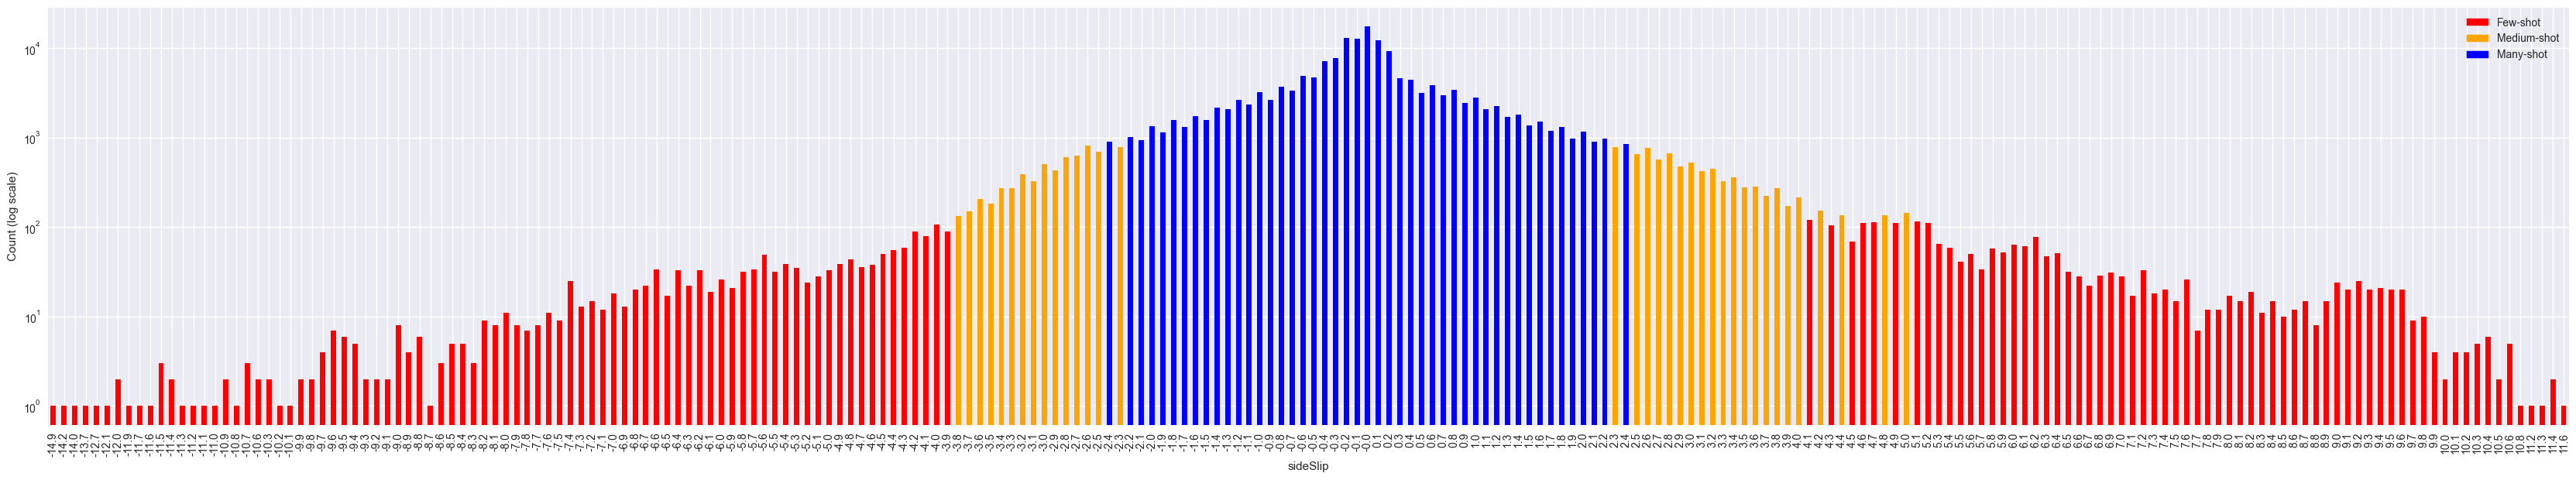

In [25]:
import matplotlib.patches as mpatches
shot_band_mapping = dist_df.groupby("sideSlip")["band"].first()
colors = shot_band_mapping.map({"few": "red", "medium": "orange", "many": "blue"})
ax = dist_df.plot(x='sideSlip', y='count', kind='bar', figsize=(42, 7), fontsize=10, color=colors)
few_patch = mpatches.Patch(color='red', label='Few-shot')
medium_patch = mpatches.Patch(color='orange', label='Medium-shot')
many_patch = mpatches.Patch(color='blue', label='Many-shot')
ax.legend(handles=[few_patch, medium_patch, many_patch], loc='upper right')
plt.yscale('log')
plt.ylabel('Count (log scale)')
plt.show()

**Key Observations from the Chart Above:**

1. **Logarithmic Scale**: The y-axis uses log scale because the difference between many-shot and few-shot is enormous (note how few-shot bars are barely visible!)

2. **Peak at Zero**: The highest bars are around 0° sideslip - this makes sense as most driving happens with minimal sideslip

3. **Symmetric Distribution**: Extreme positive and negative sideslip angles are equally rare (both left and right turns/slides)

4. **The Challenge**: The red bars (few-shot) are tiny but represent the most important scenarios for vehicle safety

Now let's see how this distribution looks in your actual training data. This visualization will help you understand:

- **Where the challenging data points are located** in your training sequences
- **How sparse the few-shot (red) samples are** compared to many-shot (blue)
- **Whether extreme sideslip events cluster together** (hint: they often do during extreme maneuvers)

**What to expect**: You'll see mostly blue dots (normal driving) with occasional orange and red clusters (challenging scenarios like sharp turns, emergency maneuvers, or slippery conditions).

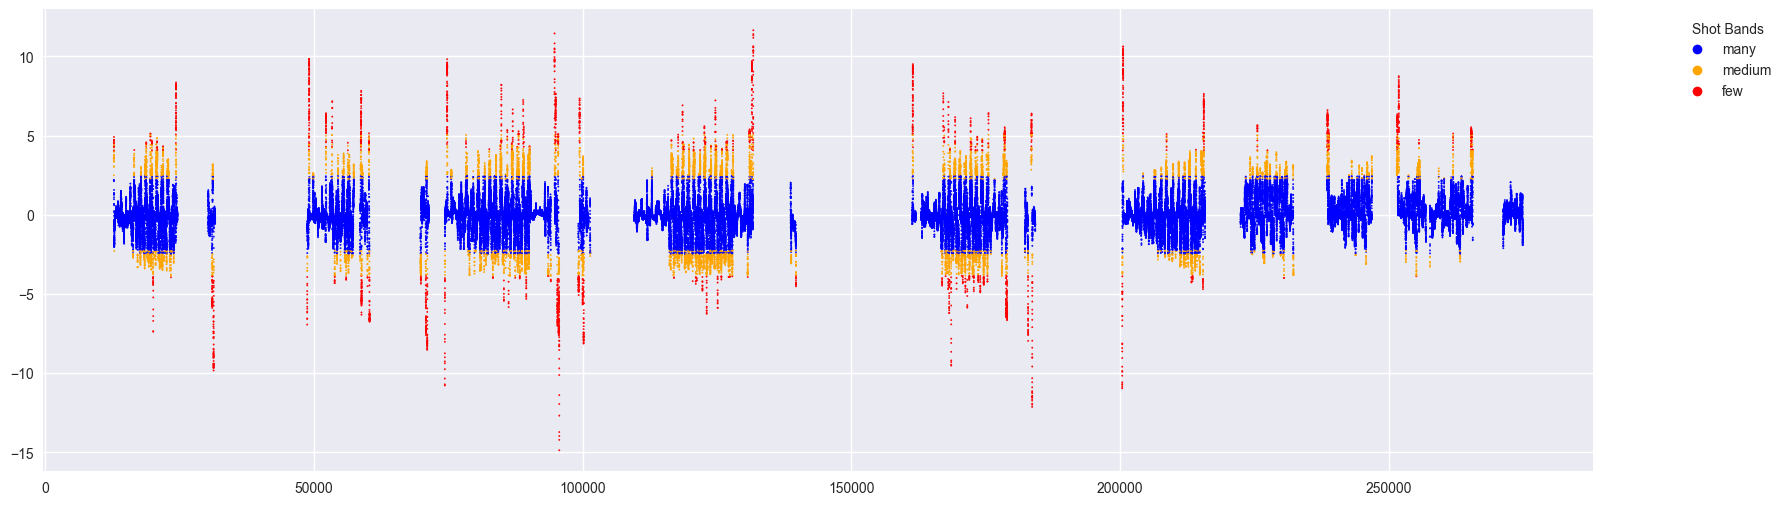

In [26]:
def concate_csv_dir(base_dir):
    all_dfs = []
    csv_lengths = {}
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                relative_path = os.path.relpath(file_path, base_dir)
                csv_lengths[relative_path] = len(df)
                all_dfs.append(df)
    
    return all_dfs, csv_lengths


df_list, csv_lengths = concate_csv_dir("datasets_challenge/train")
train_df = pd.concat(df_list, ignore_index=True)
train_df = train_df.where(train_df["vxCG"] > 3.0).dropna()  # Apply the same thresholding as during training


train_df["band"] = train_df["sideSlip"].round(1).map(shot_band_mapping)

plt.figure(figsize=(20, 6))
plt.scatter(train_df.index, train_df["sideSlip"], c=train_df["band"].map({"many": "blue", "medium": "orange", "few": "red"}), s=1)
# Plot the color code in a legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=7, label='many'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=7, label='medium'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, label='few')],
           title="Shot Bands", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 🎯 Testing Your Model with the Challenge Metric

Now comes the moment of truth! Let's evaluate your baseline model using the same metric that will be used in the official competition.

**Understanding the Metric:**
- **Dual Evaluation**: You'll get separate MAE scores for many-shot and few-shot regions
- **Success Criteria**: 
  - Few-shot MAE should be as low as possible (this is your primary score)
  - Many-shot MAE must stay ≤ 0.2° (constraint to prevent degradation)
- **Real Competition**: The Kaggle version is slightly different but gives equivalent results

**What to Expect**: Your baseline model will likely show good many-shot performance but struggle with few-shot cases - this is the challenge you need to solve!

In [27]:
from utils.kaggle_metric import score

gt_df = pd.DataFrame({"ground_truth_sideslip": ground_truths}, dtype=np.float64)
gt_df["id"] = range(len(ground_truths))
gt_df["band"] = gt_df["ground_truth_sideslip"].round(1).map(shot_band_mapping).fillna("unknown")


preds_df = pd.DataFrame({"id": range(len(preds)), "predicted_sideslip": preds})

score(gt_df, preds_df, row_id_column_name="id")

band
few       0.262102
many      0.127145
medium    0.186635
Name: L1, dtype: float64

**Performance Analysis:**
- **Many-Shot MAE: ~0.18°** ✅ (Good! Below the 0.2° threshold)
- **Few-Shot MAE: ~1.00°** 🔍 (This is your improvement target)

**What This Tells Us:**
1. **Your model works well for normal driving** - it can predict sideslip accurately when angles are small
2. **Extreme situations are challenging** - the model struggles with rare, critical scenarios
3. **Room for Improvement**: A 5x difference in performance between regions shows the classic imbalanced regression problem

**Data Distribution Context:**
Looking at the data counts below, you can see why this happens - you have ~90% many-shot data vs ~1% few-shot data for training.

**Your Mission in this Challenge**: Can you develop techniques to improve few-shot performance while maintaining many-shot accuracy?

In [25]:
gt_df["band"].value_counts()

band
many      124956
medium      9521
few         2603
Name: count, dtype: int64

And thats all. I hope you now got a feeling for:
- **Data Loading & Preprocessing**: Proper train/validation/test splitting with consistent preprocessing
- **Neural Network Training**: RNN architecture with best practices (early stopping, checkpointing)
- **Model Evaluation**: Understanding training curves and validation metrics  
- **Competition Submission**: Generating predictions in the correct format
- **Imbalanced Regression**: Recognizing and evaluating performance across different data regions

## **Good Luck with the Challange** 🏁